In [ ]:
import subprocess
import sys

COLAB = "google.colab" in sys.modules


def _install(package):
    if COLAB:
        ans = input(f"Install { package }? [y/n]:")
        if ans.lower() in ["y", "yes"]:
            subprocess.check_call(
                [sys.executable, "-m", "pip", "install", "--quiet", package]
            )
            print(f"{ package } installed!")


def _colab_install_missing_deps(deps):
    import importlib

    for dep in deps:
        if importlib.util.find_spec(dep) is None:
            if dep == "iris":
                dep = "scitools-iris"
            _install(dep)


deps = ["erddapy"]
_colab_install_missing_deps(deps)

# Fetching data from CO-OPS ERDDAP with Python tools

Created: 2016-10-12

Updated: 2022-05-26

In this post we will use `erddapy` to find and download data from the
[Center for Operational Oceanographic Products and Services (CO-OPS)](https://opendap.co-ops.nos.noaa.gov/erddap/) ERDDAP server.

Here we will fetch data during the [hurricane Matthew](https://en.wikipedia.org/wiki/Hurricane_Matthew) passage over the southeast states from 2016-10-05 to 2016-10-12. The first step is to instantiate the server object and then add the constraints for our query.

In [1]:
from erddapy import ERDDAP

e = ERDDAP(
    server="https://opendap.co-ops.nos.noaa.gov/erddap",
    protocol="tabledap",
)

The geographical bounding box includes all the states in the [SECOORA](http://secoora.org/) region: Florida, Georgia, South and North Carolina.

In [2]:
min_lat, max_lat = 24.25, 36.70
min_lon, max_lon = -87.40, -74.70

In [3]:
import folium

lon = (min_lon + max_lon) / 2
lat = (min_lat + max_lat) / 2

m = folium.Map(location=[lat, lon], tiles="OpenStreetMap", zoom_start=5)

folium.Polygon(
    [(min_lat, min_lon), (max_lat, min_lon), (max_lat, max_lon), (min_lat, max_lon)],
    fill=True,
).add_to(m)

m

Unfortunately, as you'll notice below, adding the bounding box as a constraint won't help because this ERDDAP server requires the `STATION_ID` number as a mandatory argument for the request.

So, this means we need to know them before making the request and we cannot get them from the server.

In [4]:
e.constraints = {
    "BEGIN_DATE=": "2016-10-04",
    "END_DATE=": "2016-10-12",
    "DATUM=": "MSL",
}

We can check all the `dataset_id` that are available within those constraints with the search URL.

In [5]:
import pandas as pd

df = pd.read_csv(e.get_search_url(response="csv"))
df["Dataset ID"]

0                                 allDatasets
1                                IOOS_Air_Gap
2                    IOOS_Raw_Currents_Header
3                           IOOS_Raw_Currents
4                        IOOS_Air_Temperature
5                    IOOS_Barometric_Pressure
6                           IOOS_Conductivity
7                      IOOS_Relative_Humidity
8                             IOOS_Visibility
9                      IOOS_Water_Temperature
10                                  IOOS_Wind
11               IOOS_Raw_One_Min_Water_Level
12                       IOOS_Raw_Water_Level
13            IOOS_Daily_Verified_Water_Level
14         IOOS_High_Low_Verified_Water_Level
15    IOOS_Hourly_Height_Verified_Water_Level
16          IOOS_Monthly_Verified_Water_Level
17           IOOS_SixMin_Verified_Water_Level
Name: Dataset ID, dtype: object

We want the `dataset_id` = `IOOS_Hourly_Height_Verified_Water_Level` to check the hourly sea surface height time-series. However, we still do not know the actual variable name. Unfortunately, the [Climate and Forecast conventions (CF)](https://cfconventions.org/) do not define the **variable names** but it does define some variable metadata attributes like `standard_name`, making it easy to check what is in a dataset. The data we are looking for should be associated with the CF `standard_name` = [`water_surface_height_above_reference_datum`](https://cfconventions.org/Data/cf-standard-names/current/build/cf-standard-name-table.html).

In `erddapy` one can query the available variables for a standard name with the method `get_var_by_attr`.

In [6]:
dataset_id = "IOOS_Hourly_Height_Verified_Water_Level"
std_name = "water_surface_height_above_reference_datum"

e.dataset_id = dataset_id

variables = e.get_var_by_attr(standard_name=std_name)

print(f"Found {','.join(variables)} variable(s) in the dataset.")


variables.extend(["time"])  # we also want to download the time.
e.variables = variables

Found WL_VALUE variable(s) in the dataset.


We found 1 variable, which makes our job easier, and now we can query the data for it.

Now we need to get a list of stations that are within our bounding box.
If we look the `STATION_ID` metadata we see a link to a page with the stations and their sensors listing.

In [7]:
info = pd.read_csv(e.get_info_url(response="csv"))
station_id_info = info.loc[info["Variable Name"] == "STATION_ID"]

station_id_info

,Row Type,Variable Name,Attribute Name,Data Type,Value
15,variable,STATION_ID,NaN,String,NaN
16,attribute,STATION_ID,cf_role,String,timeseries_id
17,attribute,STATION_ID,comment,String,To view the station id listing go to: https://...
18,attribute,STATION_ID,ioos_category,String,Identifier
19,attribute,STATION_ID,long_name,String,REQUIRED 7-character Station ID surrounded in ...


In [8]:
print(
    station_id_info.loc[station_id_info["Attribute Name"] == "comment"][
        "Value"
    ].squeeze()
)

To view the station id listing go to: https://opendap.co-ops.nos.noaa.gov/stations/index.jsp


In that page we have the option to view stations information as XML (`stationsXML`).
Luckily we can easily parse the stationsXML file and filter out the stations we want.

In [9]:
url = "https://opendap.co-ops.nos.noaa.gov/stations/stationsXML.jsp"


names = pd.read_xml(
    url,
    namespaces={"xsi": "http://www.w3.org/2001/XMLSchema-instance"},
)[["name", "ID"]]


locations = pd.read_xml(url, xpath='//*[contains(name(),"location")]')

df = pd.concat([names, locations], axis=1)

Now we can filter the stations that are inside our bounding box.

In [10]:
mask = (
    (df["lat"] >= min_lat)
    & (df["lat"] <= max_lat)
    & (df["long"] >= min_lon)
    & (df["long"] <= max_lon)
)

df = df[mask]

print(
    f"We filtered out all stations but those from {', '.join(filter(None, set(df['state'])))} states."
)

We filtered out all stations but those from GA, SC, FL, NC states.


That looks correct. We want only the stations that are part of the [SECOORA region](https://secoora.org/).

In [11]:
data = {}

for station_id in df["ID"]:
    e.constraints.update({"STATION_ID=": f"{station_id}"})
    try:
        series = e.to_pandas(index_col="time (UTC)", parse_dates=True)
        data.update({station_id: series})
    except Exception:
        missing = df.loc[df["ID"] == station_id][["name", "ID"]].squeeze().tolist()
        print(
            f"Could not get data for {missing[0]} id {missing[1]} using the URL:\n\n"
            f"{e.get_download_url()}\n"
        )
        pass

water_level = pd.concat(data, axis=1)

# Remove the units and leave only the station number.
water_level.columns = [col[0] for col in water_level.columns]

Could not get data for Don Holt Bridge Air Gap id 8664753 using the URL:

https://opendap.co-ops.nos.noaa.gov/erddap/tabledap/IOOS_Hourly_Height_Verified_Water_Level.html?WL_VALUE,time&BEGIN_DATE="2016-10-04"&END_DATE="2016-10-12"&DATUM="MSL"&STATION_ID="8664753"

Could not get data for Ravenel Bridge Air Gap id 8665353 using the URL:

https://opendap.co-ops.nos.noaa.gov/erddap/tabledap/IOOS_Hourly_Height_Verified_Water_Level.html?WL_VALUE,time&BEGIN_DATE="2016-10-04"&END_DATE="2016-10-12"&DATUM="MSL"&STATION_ID="8665353"

Could not get data for Talmadge Memorial Bridge Air Gap id 8670674 using the URL:

https://opendap.co-ops.nos.noaa.gov/erddap/tabledap/IOOS_Hourly_Height_Verified_Water_Level.html?WL_VALUE,time&BEGIN_DATE="2016-10-04"&END_DATE="2016-10-12"&DATUM="MSL"&STATION_ID="8670674"

Could not get data for Kings Bay MSF Pier id 8679598 using the URL:

https://opendap.co-ops.nos.noaa.gov/erddap/tabledap/IOOS_Hourly_Height_Verified_Water_Level.html?WL_VALUE,time&BEGIN_DATE="2016-

Many requests failed because we don't know if the data for that station exists in the date range we requested. That ERDDAP server is not configured to use what ERDDAP does best, high queries using the metadata.

Now that we have the data we can, for example, check the station with the highest sea elevation.

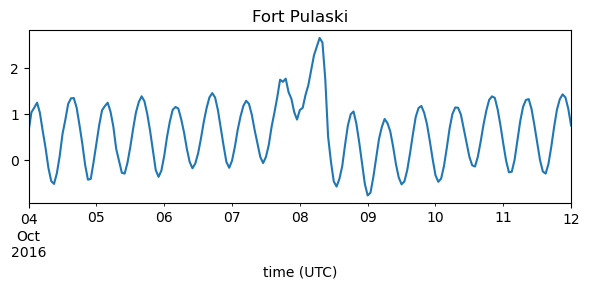

In [12]:
def get_station_name(station_id):
    return df.loc[df["ID"] == station_id]["name"].squeeze()


station_id = water_level.max(axis=0).idxmax()

ax = water_level[station_id].plot(figsize=(7, 2.25))
title = ax.set_title(get_station_name(station_id))

Let's plot the stations from North Carolina so we can compare with Fort Pulaski, GA.

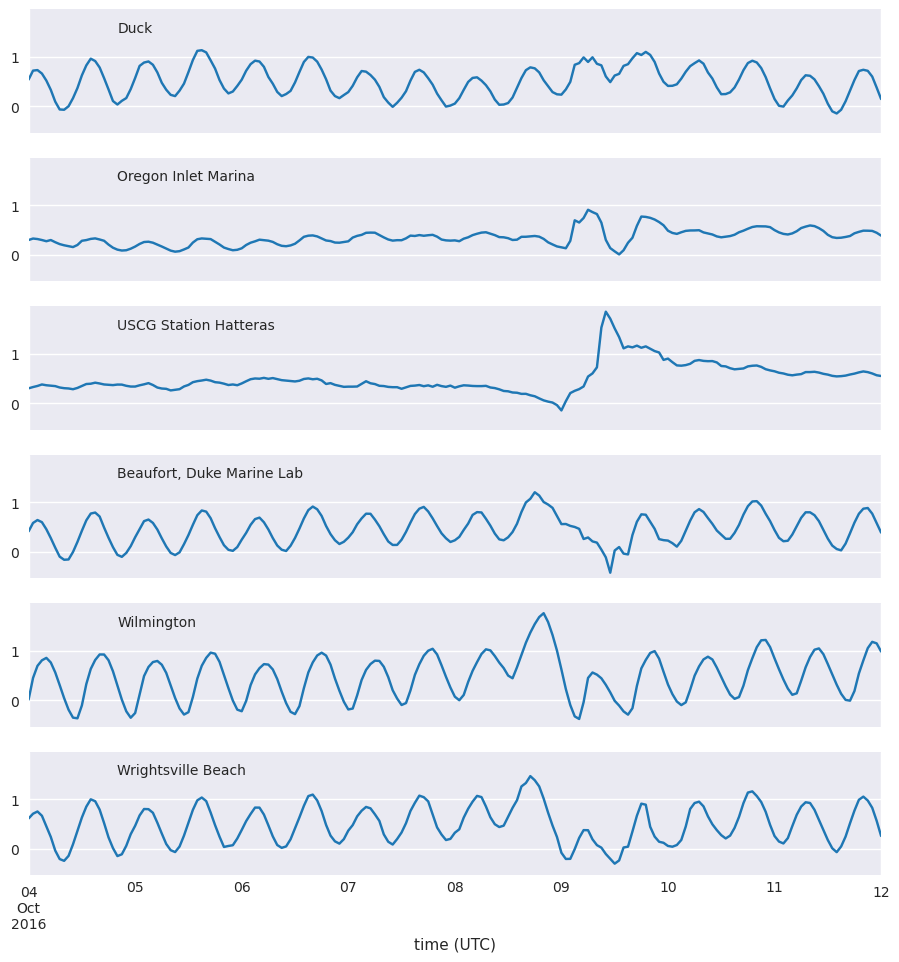

In [13]:
import matplotlib
import matplotlib.pyplot as plt

station_ids = df.loc[df["state"] == "NC"]["ID"]

with matplotlib.style.context(["seaborn-notebook", "seaborn-darkgrid"]):
    fix, axes = plt.subplots(
        nrows=len(station_ids), sharex=True, sharey=True, figsize=(11, 2.25 * 5)
    )

    for k, station_id in enumerate(station_ids):
        series = water_level[station_id]
        series.plot(ax=axes[k])
        axes[k].text(series.index[20], 1.5, get_station_name(station_id))

Ideally we should filter out the tides in order to better interpret the storm surges.
We'll leave that as an exercise to the readers.

In order to easily explore all the stations we can put together an interactive map with the stations positions and the elevation time-series.
This can be done using the software package `bokeh` and the mapping library `folium`.

In [14]:
from bokeh.embed import file_html
from bokeh.plotting import figure
from bokeh.resources import CDN
from folium import IFrame

# Plot defaults.
tools = "pan,box_zoom,reset"
width, height = 750, 250


def make_plot(series):
    p = figure(
        toolbar_location="above",
        x_axis_type="datetime",
        width=width,
        height=height,
        tools=tools,
        title=f"{get_station_name(series.name)} ({series.name})",
    )
    line = p.line(
        x=series.index,
        y=series.values,
        line_width=5,
        line_cap="round",
        line_join="round",
    )
    return p, line


def make_marker(p, location, fname):
    html = file_html(p, CDN, fname)
    iframe = IFrame(html, width=width + 45, height=height + 80)

    popup = folium.Popup(iframe, max_width=2650)
    icon = folium.Icon(color="green", icon="stats")
    marker = folium.Marker(location=location, popup=popup, icon=icon)
    return marker

In [15]:
lon = (min_lon + max_lon) / 2
lat = (min_lat + max_lat) / 2

m = folium.Map(location=[lat, lon], tiles="OpenStreetMap", zoom_start=5)

for station_id, series in water_level.items():
    location = df.loc[df["ID"] == station_id][["lat", "long"]].squeeze().tolist()
    p, _ = make_plot(series)
    marker = make_marker(p, location=location, fname=station_id)
    marker.add_to(m)

m